# ANHIR: Evaluation Board

This notebook serves as visualisation for challenge results in several forms - standard tables and charts. First, all submissions have to be recomputed, so they also contain the detail about each image registration pair. One of the perspective to validate is the difference between training and testing.

The ANHIR challenge is hosted on https://anhir.grand-challenge.org.

These particular results are for ANHIR workshop hosted at ISBI 2019 in Venice, Italy.
In case you want to get some further evaluation related to new submission, you may contact one of the ANHIR administrators because the full submission is required, see https://anhir.grand-challenge.org/Organizers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.drawing import RadarChart, draw_matrix_user_ranking
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [2]:
# folder with all participants submissions
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions_paper')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'

## Parse and load submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [3]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip -o "%s" -d "%s"' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 13/13 [00:02<00:00,  3.66it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [ ]:
import bm_ANHIR.evaluate_submission

for path_sub in tqdm.tqdm(submission_dirs, desc='evaluation'):
    print(path_sub)
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_table=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1.,
        details=True,
        allow_inverse=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))

**Load parsed measures from each submission/experiment/participant.**

In [4]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 13/13 [00:00<00:00, 97.61it/s]

Users: dict_keys(['AGH', 'ANTs', 'CKVST', 'DROP', 'Elastix', 'MEVIS', 'NiftyReg', 'RVSS', 'TUB', 'TUNI', 'UA', 'UPENN', 'bUnwarpJ'])


In [5]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['COAD', 'breast', 'gastric', 'kidney', 'lung-lesion', 'lung-lobes', 'mammary-gland', 'mice-kidney']


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [6]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        for robust in [True, False]:  # iterate over Robust or all cases
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '_tissue_' + tissue] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [7]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_'])]
pd.set_option("display.max_columns", 25)
pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]

,Average-Robustness,Average-Rank-Median-rTRE,Average-Rank-Max-rTRE,Average-used-landmarks,Average-Median-rTRE,Average-Median-rTRE-Robust,Median-Median-rTRE,Median-Median-rTRE-Robust,Average-Max-rTRE,Average-Max-rTRE-Robust,Median-Max-rTRE,Median-Max-rTRE-Robust,Average-Average-rTRE,Average-Average-rTRE-Robust,Median-Average-rTRE,Median-Average-rTRE-Robust,Average-Norm-Time,Average-Norm-Time-Robust,Median-Norm-Time,Median-Norm-Time-Robust,Average-Rank-Median-rTRE-Robust,Average-Rank-Max-rTRE-Robust
UPENN,0.945420,3.367983,3.923077,1.048696,0.008628,0.002755,0.001937,0.001892,0.032779,0.023254,0.018851,0.017570,0.009987,0.004045,0.003048,0.002958,1.451193,1.448465,1.374846,1.374846,3.367983,3.923077
TUB,0.949311,2.725572,2.332640,1.048802,0.009902,0.002823,0.001053,0.000818,0.024638,0.013072,0.004853,0.003372,0.010608,0.003447,0.001289,0.000941,0.000705,0.000715,0.000510,0.000510,2.704167,2.310417
AGH,0.927517,3.457380,5.694387,1.028838,0.011783,0.003715,0.002030,0.001929,0.042077,0.030274,0.023648,0.023067,0.013646,0.005597,0.003504,0.003365,6.863679,6.807467,5.791019,5.764027,3.457380,5.694387
MEVIS,0.934990,2.923077,4.503119,1.046140,0.012266,0.002879,0.001846,0.001784,0.039758,0.024610,0.019193,0.018597,0.013490,0.004288,0.002983,0.002834,0.145392,0.144903,0.141754,0.142006,2.923077,4.503119
CKVST,0.916941,5.725572,5.388773,1.041394,0.014103,0.004551,0.003592,0.003410,0.041267,0.026207,0.021663,0.020835,0.015427,0.005989,0.004868,0.004704,7.127142,7.149948,7.488842,7.508170,5.725572,5.388773
TUNI,0.846745,5.744283,5.931393,1.053976,0.014412,0.005580,0.002580,0.002141,0.044418,0.029453,0.024138,0.020538,0.016083,0.007085,0.003768,0.003288,10.320549,9.154738,8.977965,8.765468,5.139588,5.372998
RVSS,0.766317,8.889813,7.966736,1.011615,0.046925,0.009244,0.005658,0.004139,0.103438,0.038073,0.029907,0.023139,0.048591,0.010898,0.007197,0.005415,4.723187,5.074618,4.881740,5.160213,8.467933,7.439430
UA,0.774761,9.278586,8.361746,1.054087,0.060087,0.013111,0.009440,0.007144,0.127694,0.043673,0.036996,0.031842,0.062057,0.014761,0.011315,0.008960,1.470925,1.454990,1.367489,1.369416,9.106754,8.150327
ANTs,0.855285,7.661123,6.723493,1.024760,0.064492,0.045016,0.004541,0.003933,0.130069,0.098920,0.028962,0.026478,0.065606,0.046010,0.006167,0.005488,109.861230,109.523678,103.731413,103.732624,7.631799,6.688285
bUnwarpJ,0.757951,8.898129,8.817048,1.026176,0.080850,0.053557,0.025498,0.016378,0.150757,0.111488,0.065109,0.049806,0.080933,0.054343,0.027901,0.017605,9.151172,9.262783,7.469397,7.533855,8.887029,8.803347


Show separatlyraw table with statistic for tran and tes cases separatly.

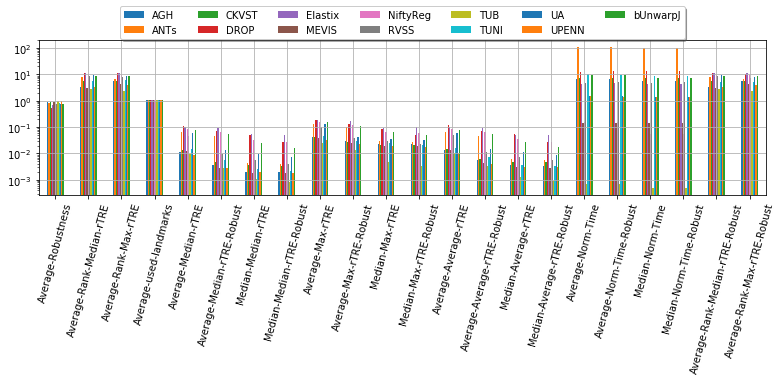

In [11]:
ax = pd.DataFrame(user_aggreg).T[cols_general].T.plot.bar(figsize=(len(cols_general) / 2, 6),
                                                          grid=True, logy=True, rot=75)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
             ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_teams-scores.pdf'))
# plt.savefig(os.path.join(PATH_TEMP, 'fig_teams-scores.pdf'), constrained_layout=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [12]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Median_rank', 'Rank-Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE'),
                         ('rTRE-Max_rank', 'Rank-Max-rTRE'),
                         ('Norm-Time_minutes', 'Norm-Time')]:
    for user in users:
        for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user]['Average-' + field_agg + '_' + state] = np.nanmean(vals)

Display just raw table with results.

In [13]:
df = pd.DataFrame(user_aggreg).T
cols_train_test = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
df.sort_values('Average-Median-rTRE')[cols_train_test].to_csv('stat-results_train-test.csv')

In [14]:
from IPython.display import display

df_train_eval = pd.DataFrame()

for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in cols_train_test if state in col]
    df = pd.DataFrame(user_aggreg).T[cols]
    df.columns = [c.replace('_' + state, '') for c in df.columns]
    df['state'] = state
    df_train_eval = pd.concat([df_train_eval, df])

# df = pd.DataFrame(user_aggreg).T[cols]
# cols = [c for c in df_all_train_eval.columns if 'state' not in c and c in df.columns]
# df = df[cols]
# df['state'] = 'all'
# df_all_train_eval = pd.concat([df_all_train_eval, df])

df_train_eval['method'] = df_train_eval.index
df_train_eval = df_train_eval.set_index(['method', 'state']).sort_index()
df_train_eval.to_csv(os.path.join(PATH_TEMP, 'results-methods_tran-test.csv'))
display(df_train_eval)

Average-Average-rTRE  Median-Average-rTRE  \
method   state                                                   
AGH      evaluation              0.018040             0.003364   
         training                0.008851             0.003781   
ANTs     evaluation              0.095732             0.006169   
         training                0.032730             0.006128   
CKVST    evaluation              0.018528             0.003485   
         training                0.012042             0.006126   
DROP     evaluation              0.142583             0.067212   
         training                0.085770             0.038545   
Elastix  evaluation              0.127950             0.063077   
         training                0.068801             0.044412   
MEVIS    evaluation              0.018120             0.002922   
         training                0.008438             0.003032   
NiftyReg evaluation              0.113517             0.037673   
         training                0.050301             0.033469   
RVSS     evaluation              0.050012             0.006338   
         training                0.047040             0.008092   
TUB      evaluation              0.019461             0.003013   
         training                0.000946             0.000126   
TUNI     evaluation              0.016728             0.003288   
         training                0.015379             0.005211   
UA       evaluation              0.063172             0.010250   
         training                0.060840             0.011664   
UPENN    evaluation              0.014832             0.003019   
         training                0.004700             0.003106   
bUnwarpJ evaluation              0.112041             0.029742   
         training                0.046985             0.024586   

                     Average-Median-rTRE  Median-Median-rTRE  \
method   state                                                 
AGH      evaluation             0.003590            0.001976   
         training               0.004042            0.002166   
ANTs     evaluation             0.099021            0.004410   
         training               0.031168            0.004574   
CKVST    evaluation             0.002697            0.002357   
         training               0.006701            0.005108   
DROP     evaluation             0.141490            0.066131   
         training               0.084502            0.037178   
Elastix  evaluation             0.128899            0.060253   
         training               0.067754            0.043466   
MEVIS    evaluation             0.002880            0.001815   
         training               0.004924            0.001890   
NiftyReg evaluation             0.113703            0.036655   
         training               0.049148            0.031194   
RVSS     evaluation             0.044767            0.004955   
         training               0.045304            0.006542   
TUB      evaluation             0.007757            0.002077   
         training               0.000111            0.000106   
TUNI     evaluation             0.004787            0.002092   
         training               0.013028            0.003284   
UA       evaluation             0.050646            0.008669   
         training               0.059492            0.009985   
UPENN    evaluation             0.002872            0.001916   
         training               0.002717            0.001986   
bUnwarpJ evaluation             0.110553            0.026814   
         training               0.045769            0.023791   

                     Average-Max-rTRE  Median-Max-rTRE  Average-Robustness  \
method   state                                                               
AGH      evaluation          0.028262         0.023409            0.903180   
         training            0.031823         0.024018            0.954075   
ANTs     evaluation          0.187804         0.029201            0

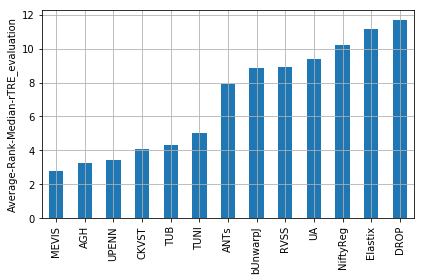

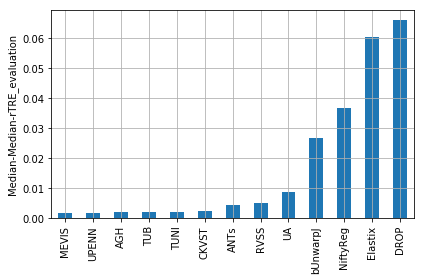

In [15]:
for col in ['Average-Rank-Median-rTRE_evaluation', 'Median-Median-rTRE_evaluation']:
    plt.figure(figsize=(6, 4))
    ax = pd.DataFrame(user_aggreg).T.sort_values(col)[col].plot.bar(grid=True, rot=90)
    _= plt.ylabel(col)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bar_teams-scores_%s.pdf' % col))

Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [22]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['method'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try: df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception: pass
# df_cases.head()

### Showing several violine plots

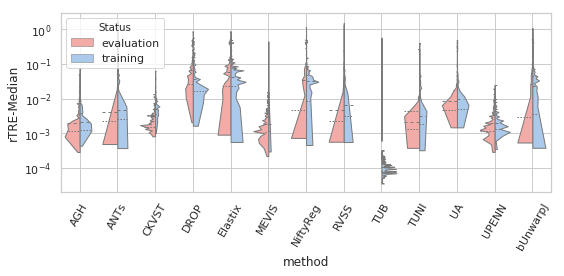

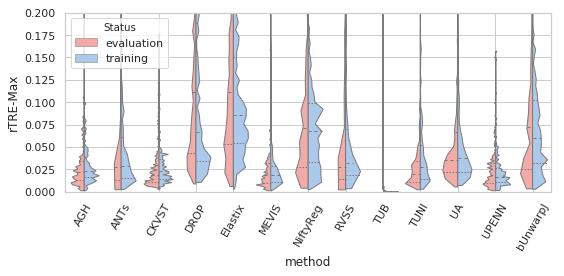

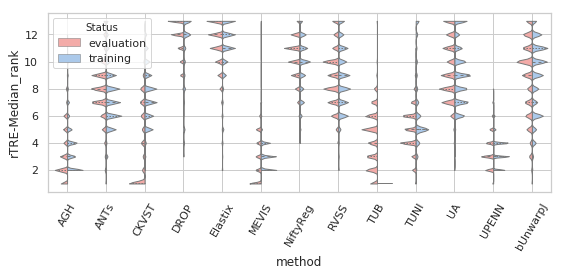

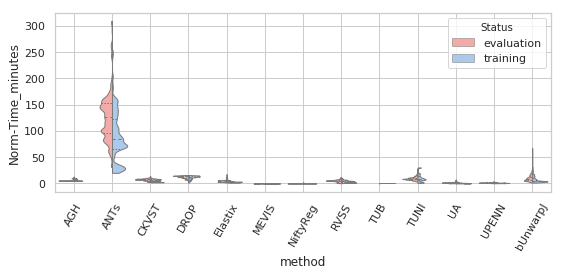

In [23]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, log, vmax, bw in [('rTRE-Median', True, None, 0.01),
                             # ('rTRE-Median', False, 0.1, 0.01),
                             ('rTRE-Max', False, 0.2, 0.02),
                             ('rTRE-Median_rank', False, None, 0.05),
                             ('Norm-Time_minutes', False, None, 0.1)]:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(ax=ax, data=df_cases, hue='Status', y=field, x='method',
                   cut=0, split=True, bw=bw, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1.)
    plt.xticks(rotation=60)
    if log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'hist_teams-scores_%s.pdf' % field))

## Visualise global results

/home/jb/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


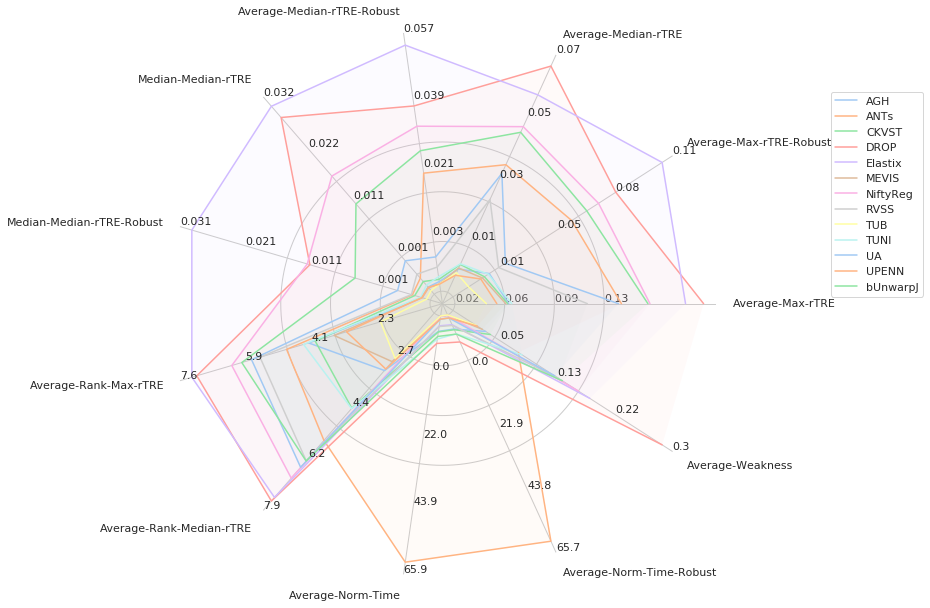

In [24]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg).T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(9, 8)))
radar.fig.tight_layout()
radar.fig.savefig(os.path.join(PATH_TEMP, 'radar_teams-scores.pdf'))

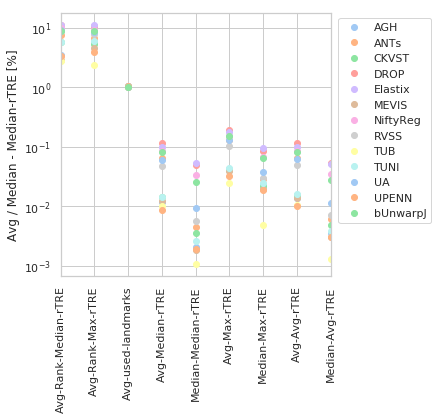

In [25]:
cols = [c for c in cols_general if 'Robus' not in c and 'Time' not in c]
dfx = pd.DataFrame(user_aggreg).T[cols]
ax = dfx.T.plot(style='o', cmap='nipy_spectral', figsize=(len(dfx) / 2, 6), grid=True)
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
_= plt.xticks(range(len(cols)), [c.replace('Average', 'Avg') for c in cols], rotation=90)
_= plt.yscale('log'), plt.ylabel('Avg / Median - Median-rTRE [%]')
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'scat_teams-scores.pdf'))

## Visualise partial rankings

With given metrics compute ranking among all participants, so each user has a unique colour and then the users are sorted in ascending order...

/home/jb/Dropbox/Workspace/BIRL/birl/utilities/evaluate.py:223: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ranking = np.zeros(df_stat.as_matrix().shape)
/home/jb/Dropbox/Workspace/BIRL/birl/utilities/drawing.py:456: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  fig, _ = plt.subplots(figsize=np.array(df_stat.as_matrix().shape[::-1]) * 0.35)


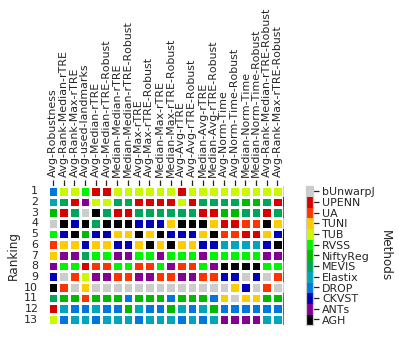

In [26]:
dfx = pd.DataFrame(user_aggreg).T[cols_general]
dfx.columns = [c.replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_all.pdf'))

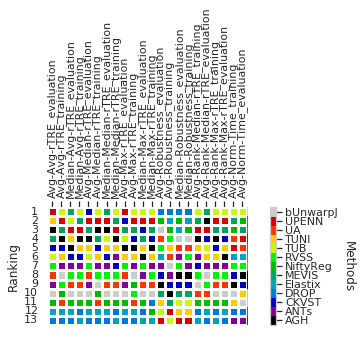

In [27]:
dfx = pd.DataFrame(user_aggreg).T[cols_train_test]
dfx.columns = [c.replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_train-test.pdf'))

## Visual statistic over tissue types

Present some statistis depending on the tissue types...

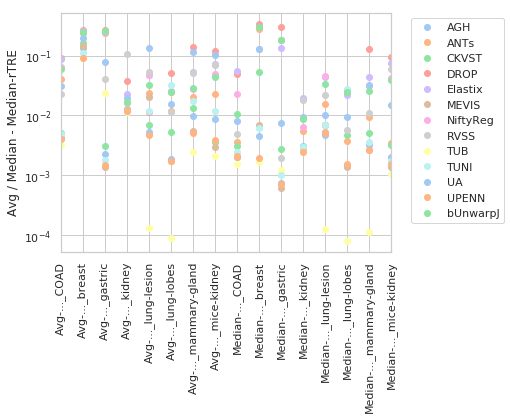

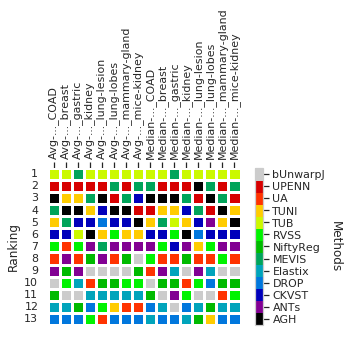

In [28]:
col_avg_med_tissue = [c for c in pd.DataFrame(user_aggreg).T.columns
                      if 'Median-rTRE_tissue' in c and not 'Rank' in c]

dfx = pd.DataFrame(user_aggreg).T[col_avg_med_tissue]
ax = dfx.T.plot(style='o', cmap='nipy_spectral', figsize=(len(dfx) / 2 + 1, 6), grid=True)
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
_= plt.xticks(range(len(col_avg_med_tissue)),
              [c.replace('Median-rTRE_tissue', '...').replace('Average', 'Avg') for c in col_avg_med_tissue],
              rotation=90)
_= plt.yscale('log'), plt.ylabel('Avg / Median - Median-rTRE')
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-avg.pdf'))

dfx.columns = [c.replace('Median-rTRE_tissue', '...').replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-avg.pdf'))

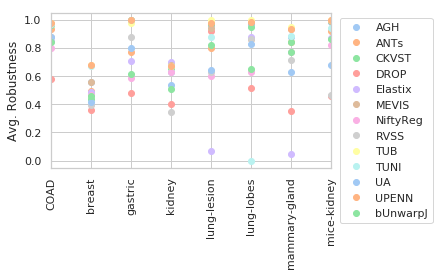

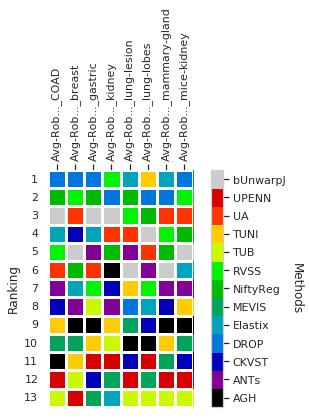

In [29]:
col_robust_tissue = [c for c in pd.DataFrame(user_aggreg).T.columns
                      if 'Average-Robustness_tissue' in c and not 'Rank' in c]
dfx = pd.DataFrame(user_aggreg).T[col_robust_tissue]
ax = dfx.T.plot(style='o', cmap='nipy_spectral', figsize=(len(dfx) / 2, 4), grid=True)
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
_= plt.xticks(range(len(col_robust_tissue)),
              [c.replace('Average-Robustness_tissue_', '') for c in col_robust_tissue],
              rotation=90)
_= plt.ylabel('Avg. Robustness')
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-robust.pdf'))

dfx.columns = [c.replace('Average-Robustness_tissue', 'Avg-Rob...') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx, fig=plt.figure(figsize=(6, 6)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-robust.pdf'))